# Predicting Salary Based on Job Features 

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, train_test_split
from category_encoders import TargetEncoder
from sklearn.metrics import mean_squared_error

In [2]:
skills_job_dim = pd.read_csv('skills_job_dim.csv')
skills_dim = pd.read_csv('skills_dim.csv')
job_postings_fact = pd.read_csv('job_postings_fact.csv')
company_dim = pd.read_csv('company_dim.csv')

encoder_location = TargetEncoder(smoothing=1.0)
encoder_skills = TargetEncoder(smoothing=1.0)

job_postings_fact['job_location_encoded'] = encoder_location.fit_transform(job_postings_fact[['job_location']], job_postings_fact['salary_year_avg'])
df = pd.merge(job_postings_fact, skills_job_dim, on='job_id', how='left')
df = pd.merge(df, skills_dim, on='skill_id', how='left')
df['skills_encoded'] = encoder_skills.fit_transform(df[['skills']], df['salary_year_avg'])

<Axes: >

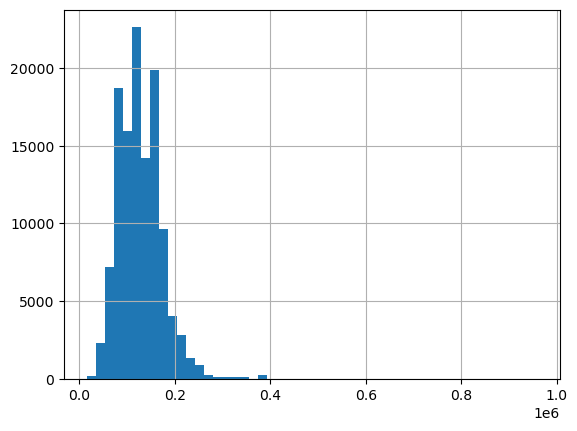

In [3]:
df['salary_year_avg'].hist(bins=50)

In [4]:
df = pd.merge(df, company_dim, on='company_id', how='left')

df = df.dropna(subset=['salary_year_avg', 'skill_id', 'company_id', 'job_title_short', 'job_health_insurance'])

df['salary_year_avg'] = np.log(df['salary_year_avg'])

features = ['job_title_short', 'job_health_insurance']
encoder_other = OneHotEncoder(handle_unknown='ignore', sparse=False)
features_encoded = encoder_other.fit_transform(df[features])

X = np.hstack((features_encoded, df[['job_location_encoded', 'skills_encoded']].values))

y = df['salary_year_avg'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

regressor = RandomForestRegressor(random_state=42)

regressor.fit(X_train_scaled, y_train)

y_pred = regressor.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error on Test Set: {rmse}')

feature_names = np.concatenate([encoder_other.get_feature_names_out(), ['job_location_encoded', 'skills_encoded']])
importances = regressor.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

categories = []
for feature in feature_names:
    if 'job_title_short' in feature:
        categories.append('Job Title')
    elif 'job_location_encoded' in feature:
        categories.append('Job Location')
    elif 'skills_encoded' in feature:
        categories.append('Skills')
    elif 'job_health_insurance' in feature:
        categories.append('Job Health Insurance')
    else:
        categories.append('Other')

feature_importance_df['Category'] = categories

category_importance = feature_importance_df.groupby('Category')['Importance'].sum().reset_index()
category_importance.sort_values('Importance', ascending=False, inplace=True)
print(category_importance)

/Users/osamajabr/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Root Mean Squared Error on Test Set: 0.2930658758771574
               Category  Importance
1          Job Location     0.41156
2             Job Title     0.28440
3                Skills     0.26986
0  Job Health Insurance     0.03418


<Axes: >

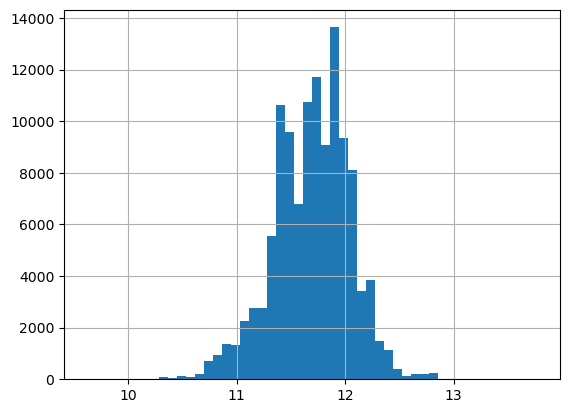

In [5]:
df['salary_year_avg'].hist(bins=50)


In [6]:
sample_data = {
    'job_title_short': ['Senior Data Scientist'],
    'job_location': ['Mountain View, CA'],
    'skills': ['java, r, sas'],
    'job_health_insurance': ['true']
}

sample_df = pd.DataFrame(sample_data)

sample_df['job_health_insurance'] = sample_df['job_health_insurance'].astype(str)

sample_df['job_location_encoded'] = encoder_location.transform(sample_df[['job_location']])


sample_df['skills_encoded'] = encoder_skills.transform(sample_df[['skills']])

features_to_encode = sample_df[['job_title_short', 'job_health_insurance']]
encoded_features = encoder_other.transform(features_to_encode)

X_sample = np.hstack([encoded_features, sample_df[['job_location_encoded', 'skills_encoded']].values])

X_sample_scaled = scaler.transform(X_sample)

log_salary_pred = regressor.predict(X_sample_scaled)

salary_pred = np.exp(log_salary_pred)

print(f'Predicted Yearly Salary: ${salary_pred[0]:,.2f}')

Predicted Yearly Salary: $193,470.04
